In [313]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.2


In [794]:
############################# IMPORT STATEMENTS ########################################################
#Import Python modules
import numpy as np
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN
from numpy import asarray
from PIL import Image
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
import cv2
import os
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from keras.callbacks import ModelCheckpoint, EarlyStopping

#For local CPU usage:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

#Import Keras modules
from keras.layers import Dense, Flatten, Input, Dropout, Conv1D, Conv2D, LSTM, Concatenate, Reshape, MaxPool1D, MaxPool2D, BatchNormalization, TimeDistributed
from keras import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import tensorflow as tf
from scipy import stats

import dlib
from imutils import face_utils
import imgaug as ia
from imgaug.augmentables.heatmaps import HeatmapsOnImage

from menpo.image import Image as menpo_image
from menpo.shape import bounding_box
from menpofit.io import load_fitter
from menpofit.aam import load_balanced_frontal_face_fitter

In [1548]:
############################# SETUP PROJECT PARAMETERS ########################################################
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

PATH_TO_DATA = 'C:/Users/Tobias/Desktop/Master-Thesis/Experiment/Lena_Eckstein/CocaCola'
IMG_FORMAT = '.jpeg'

batch_size = 32

# Approach:

### 1. Face detection
using MTCNN (Simultaneous face detection, face alignment, bounding boxing and landmark detection)

### 2. Highlighting faces
draw the bounding box in an image and plot it - to check out the result

### 3. Face extraction
extracting the face according to the identified bounding box

### 4. Face recognition
Using the VGGFace pretrained Resnet50 model to recognize emotions (training + prediction)

## 0. Get data

In [1549]:
# for now reading the RGB values of the image (maybe in future just gray-scale)
def get_image_from_filename(path_to_folder, filename):
    image = cv2.cvtColor(cv2.imread(os.path.join(path_to_folder, filename)), cv2.COLOR_BGR2RGB)
    return image

def get_image_from_filename_GRAY(path_to_folder, filename):
    image = cv2.cvtColor(cv2.imread(os.path.join(path_to_folder, filename)), cv2.COLOR_BGR2GRAY)
    return image

def get_all_images(path_to_data):
    images = []
    for folder in os.listdir(path_to_data):
        for filename in os.listdir(os.path.join(path_to_data, folder)):
            img = cv2.imread(os.path.join(path_to_data, folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
    return images

def get_all_images_no_subfolder(path_to_data):
    images = []
    for filename in os.listdir(path_to_data):
        img = cv2.imread(os.path.join(path_to_data, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

def get_all_images_GRAY(path_to_data):
    images = []
    for folder in os.listdir(path_to_data):
        for filename in os.listdir(os.path.join(path_to_data, folder)):
            img = cv2.imread(os.path.join(path_to_data, folder, filename))
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                images.append(img)
    return images

In [1550]:
# sructure data according to emotions (necessary to read in labels)
def get_labels(path_to_data):
    labels = []
    
    for folder in os.listdir(path_to_data):
        with open(os.path.join(path_to_data, folder, folder + ".json")) as p:
            data = json.load(p)
        frames = data['frames']
    
        for key, value in frames.items():
            labels.append([value['valence'], value['arousal']])

    return labels

def get_labels_from_folder(path_to_data, folder):
    labels = []
    
    with open(os.path.join(path_to_data, folder, folder + ".json")) as p:
        data = json.load(p)
    frames = data['frames']

    for key, value in frames.items():
        labels.append([value['valence'], value['arousal']])

    return labels

In [1551]:
# split data into training, cv and test
def get_splitted_data(path_to_data):
    labels = get_labels(path_to_data)
    filenames = get_all_images(path_to_data)
    
    filenames_shuffled_np, labels_shuffled_np = shuffle(filenames, labels)
    X_training, X_test, Y_training, Y_test = train_test_split(filenames_shuffled_np, labels_shuffled_np, test_size=0.2)
    
    return X_training, X_test, Y_training, Y_test

 
## 1. Face detection

In [1552]:
detector = MTCNN()

def detect_face(image):
    face = detector.detect_faces(image)
    return face

def detect_faces(images):
    faces = []  
    for img in images:
        face = detector.detect_faces(img)
        if len(face) == 1:
            faces.append(face)  ## just use the face with the highest detection probability
        elif len(face) > 1:
            faces.append(face[0])
        else:
            faces.append([]) ### no face was detected
    return faces

In [1553]:
def extract_face_from_image(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_face(image) # content of face is a python dict

    # extract the bounding box from the requested face
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height =  box
    
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
        
    return face_array


def extract_face_from_images(images, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    faces = detect_faces(images)
    face_images = []
    
    for i in range(len(images)):
        if faces[i-1] == []: # No face detected
            face_image = Image.fromarray(images[i-1])
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
        else:
            # extract the bounding box from the requested face
            if type(faces[i-1]) is list:  # checks whether more than one face was detected
                box = np.asarray(faces[i-1][0]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box
            else:
                box = np.asarray(faces[i-1]['box'])
                box[box < 0] = 0
                x1, y1, width, height = box

            x2, y2 = x1 + width, y1 + height
            # extract the face
            face_boundary = images[i-1][y1:y2, x1:x2]

            # resize pixels to the model size
            face_image = Image.fromarray(face_boundary)
            face_image = face_image.resize(required_size)
            face_array = asarray(face_image)
            face_images.append(face_array)
            
    return face_images

In [1554]:
p = "shape_predictor_68_face_landmarks.dat"
dlib_predictor = dlib.shape_predictor(p) 

def get_image_with_landmarks(image, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    face = detect_face(image)
    if face == []:
        print("No face detected!")
    else:
        elem = face[0]
        x, y, width, height = elem['box']

        rect = dlib.rectangle(left=x, top=y, right=(x+width), bottom=(y+height))
        landmarks = dlib_predictor(image, rect)

        for n in range(0,68):
            x=landmarks.part(n).x
            y=landmarks.part(n).y
            cv2.circle(image, (x, y), 4, (0, 0, 255), -1)

    img = Image.fromarray(image)
    img = img.resize(required_size)
    img = asarray(img)        
    
    return img


def get_image_with_landmarks_from_file(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image = get_image_from_filename(path_to_folder, filename)
    face = detect_face(image)
    elem = face[0]
    x, y, width, height = elem['box']
    print(elem['box'])
    
    rect = dlib.rectangle(left=x, top=y, right=(x+width), bottom=(y+height))
    print(rect)
    landmarks = dlib_predictor(image, rect)
    landmarks_list = []
    
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        cv2.circle(image, (x, y), 4, (0, 0, 255), -1)
        landmarks_list.append([x, y])
    
    img = Image.fromarray(image)
    img = img.resize(required_size)
    img = asarray(img)
    
    return img

def get_face_with_landmarks_from_file(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image = get_image_from_filename(path_to_folder, filename)
    face = detect_face(image)
    
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height
    rect = dlib.rectangle(left=x1, top=y1, right=(x1+width), bottom=(y1+height))
    print(rect)
    
    landmarks = dlib_predictor(image, rect)  
    print(landmarks)
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        cv2.circle(image, (x, y), 4, (0, 0, 255), -1)
    
     # extract the face
    face_boundary = image[y1:y2, x1:x2]
    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = asarray(face_image)
    
    return face_array

def get_heatmap_from_file(path_to_folder, filename, only_face, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image_in = get_image_from_filename(path_to_folder, filename)
    
    face_image = Image.fromarray(image_in)
    face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = asarray(face_image)
    
    face = detect_face(image)
    box = np.asarray(face[0]['box'])
    box[box < 0] = 0
    x1, y1, width, height = box
    x2, y2 = x1 + width, y1 + height
    rect = dlib.rectangle(left=x1, top=y1, right=(x1+width), bottom=(y1+height))
    
    landmarks = dlib_predictor(image, rect)
    xy  = []
    for n in range(0,68):
        x=landmarks.part(n).x
        y=landmarks.part(n).y
        xy.append([x,y])
    xy = np.float32(xy)

    kpsoi = ia.KeypointsOnImage.from_xy_array(xy, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    distance_maps = kpsoi.to_distance_maps()
    max_distance = np.linalg.norm(np.float32([IMAGE_WIDTH, IMAGE_HEIGHT]))
    distance_maps_normalized = distance_maps / max_distance

    heatmaps = HeatmapsOnImage((1.0 - distance_maps_normalized)**100, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
    img = heatmaps.draw_on_image(image)
    out = np.amax(img, axis=0)   # Maxima along the first axis
    out = np.maximum(out, image) # Maxima between original image and heatmap
    
    if only_face == True:
        face_boundary = out[y1:y2, x1:x2]
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
        image = asarray(face_image)
        return image
    else:
        return out

def get_heatmap_from_image(image_in, only_face, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):    
    face_image = Image.fromarray(image_in)
    face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    image = asarray(face_image)
    
    face = detect_face(image)
    if len(face) == 0:
        print("No Face detected")
        return image
    else: 
        box = np.asarray(face[0]['box'])
        box[box < 0] = 0
        x1, y1, width, height = box
        x2, y2 = x1 + width, y1 + height
        rect = dlib.rectangle(left=x1, top=y1, right=(x1+width), bottom=(y1+height))

        landmarks = dlib_predictor(image, rect)
        xy  = []
        for n in range(0,68):
            x=landmarks.part(n).x
            y=landmarks.part(n).y
            xy.append([x,y])
        xy = np.float32(xy)

        kpsoi = ia.KeypointsOnImage.from_xy_array(xy, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
        distance_maps = kpsoi.to_distance_maps()
        max_distance = np.linalg.norm(np.float32([IMAGE_WIDTH, IMAGE_HEIGHT]))
        distance_maps_normalized = distance_maps / max_distance

        heatmaps = HeatmapsOnImage((1.0 - distance_maps_normalized)**100, shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
        img = heatmaps.draw_on_image(image)
        out = np.amax(img, axis=0)   # Maxima along the first axis
        out = np.maximum(out, image) # Maxima between original image and heatmap

        if only_face == True:
            face_boundary = out[y1:y2, x1:x2]
            face_image = Image.fromarray(face_boundary)
            face_image = face_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
            image = asarray(face_image)
            return image
        else:
            return out

In [1555]:
def get_image_with_aam_from_file(path_to_folder, filename, required_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    image = get_image_from_filename(path_to_folder, filename)
    img = Image.fromarray(image)
    img = img.resize(required_size)
    image = asarray(img)
    
    face = detect_face(image)
    elem = face[0]
    x1, y1, width, height = elem['box']
    print(elem['box'])
    
    aam = load_balanced_frontal_face_fitter()
    bb = bounding_box((x1, y1), (x1+width, y1+height))
    
    img = np.moveaxis(image, -1, 0)
    print(img.shape)
    img = menpo_image(img, True)
    result = aam.fit_from_bb(img, bb)
    return result

In [1556]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [1557]:
def corr(y_true, y_pred):
    #normalise
    n_y_true = (y_true - K.mean(y_true[:])) / K.std(y_true[:])
    n_y_pred = (y_pred - K.mean(y_pred[:])) / K.std(y_pred[:])  

    top=K.sum((n_y_true[:]-K.mean(n_y_true[:]))*(n_y_pred[:]-K.mean(n_y_pred[:])),axis=[-1,-2])
    bottom=K.sqrt(K.sum(K.pow((n_y_true[:]-K.mean(n_y_true[:])),2),axis=[-1,-2])*K.sum(K.pow(n_y_pred[:]-K.mean(n_y_pred[:]),2),axis=[-1,-2]))

    result=top/bottom
    return K.mean(result)

In [1558]:
def corr_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)



## TESTING OF PREDICTION + INTEREST IDENTIFICATION

In [1559]:
LSTM_layer = False

In [1560]:
def custom_vgg_model():
    if LSTM_layer == True:
        model_VGGFace = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        
        model = Sequential()
        model.add(TimeDistributed(model_VGGFace, input_shape=(5, 224, 224, 3)))
        model.add(TimeDistributed(Flatten(), name='flatten'))
        model.add(LSTM(256, activation='relu', return_sequences=False, name='lstm'))
        model.add(Dropout(0.7, name='dropout'))
        model.add(Dense(1024, activation='relu', name='dense'))
        model.add(Dropout(0.6, name='dropout2'))
        model.add(BatchNormalization(name='batchNorm'))
        model.add(Dense(2, activation='tanh', name='out'))
        return model
        
    else:
        model_VGGFace = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        last_layer = model_VGGFace.get_layer('avg_pool').output    
        print(last_layer.shape)

        x = Flatten(name='flatten')(last_layer)
        x = Dropout(0.7)(x)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.6)(x)
        x = BatchNormalization()(x)

        out1 = Dense(1, activation='tanh', name='out1')(x)
        out2 = Dense(1, activation='tanh', name='out2')(x)

        custom_vgg_model = Model(inputs= model_VGGFace.input, outputs= [out1, out2])
        return custom_vgg_model

In [1561]:
from datetime import datetime

In [1576]:
t0 = datetime.now()
model = custom_vgg_model()
print("Hello - I am here!")
if LSTM_layer == True:
    for layer in model.layers:
        if hasattr(layer, 'layer') and layer.layer.name == 'vggface_resnet50':
            print(layer.layer.name)
            layer.layer.load_weights("model_checkpoints/lstm/VGGFace.h5")
        elif layer.name == 'flatten' or layer.name == 'dropout' or layer.name == 'dropout2':
            print("Not set: " + layer.name)
        else:
            print(layer.name)
            weights = np.load("model_checkpoints/lstm/weights_" + str(layer.name) + ".npy", allow_pickle=True)
            layer.set_weights(weights)
else:
    model.load_weights("model_checkpoints/model_best_v26.h5")

t1 = datetime.now()
seconds = t1 - t0
print("Time to load the model in hh:mm:ss ")
print(seconds)
model.summary()

(?, 1, 1, 2048)
Hello - I am here!
Time to load the model in hh:mm:ss 
0:06:58.140765
Model: "model_198"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_198 (InputLayer)          (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_198[0][0]                  
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_3627 (Activation)    (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
____

conv4_4_1x1_increase/bn (BatchN (None, 14, 14, 1024) 4096        conv4_4_1x1_increase[0][0]       
__________________________________________________________________________________________________
add_1195 (Add)                  (None, 14, 14, 1024) 0           conv4_4_1x1_increase/bn[0][0]    
                                                                 activation_3657[0][0]            
__________________________________________________________________________________________________
activation_3660 (Activation)    (None, 14, 14, 1024) 0           add_1195[0][0]                   
__________________________________________________________________________________________________
conv4_5_1x1_reduce (Conv2D)     (None, 14, 14, 256)  262144      activation_3660[0][0]            
__________________________________________________________________________________________________
conv4_5_1x1_reduce/bn (BatchNor (None, 14, 14, 256)  1024        conv4_5_1x1_reduce[0][0]         
__________

In [1577]:
images = get_all_images_no_subfolder(PATH_TO_DATA)
print(len(images))

151


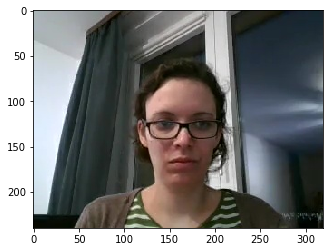

In [1578]:
plt.imshow(images[1])

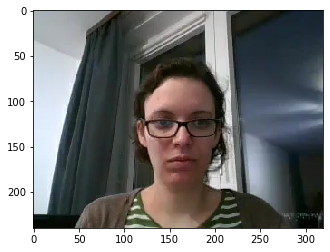

In [1579]:
plt.imshow(images[0])

In [1580]:
faces = extract_face_from_images(images)
faces = np.array(faces)

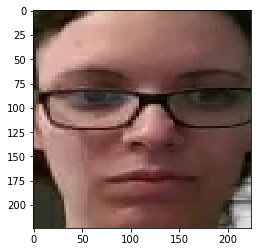

In [1581]:
plt.imshow(faces[1])

In [1582]:
t2 = datetime.now()
if LSTM_layer == True:
    buffer = []
    buffer_all = []

    for face in faces:
        buffer.append(face)
        if len(buffer) == 5:
            buffer_all.append(np.array(buffer))
            buffer.pop(0)

    result = model.predict(np.array(buffer_all))
    results = np.around(np.array(result),2)

    for elem in results[:,0]:
        print(elem)

    emotion_scores = results[:,0]
else:
    results = model.predict(faces)
    emotion_scores = np.array(results[0])
    emotion_scores = np.around(emotion_scores, 2)
    print(emotion_scores)
    emotion_arousal = np.around(np.array(results[1]), 2)

[[0.08]
 [0.08]
 [0.11]
 [0.1 ]
 [0.07]
 [0.09]
 [0.06]
 [0.03]
 [0.07]
 [0.06]
 [0.08]
 [0.06]
 [0.05]
 [0.07]
 [0.07]
 [0.08]
 [0.08]
 [0.08]
 [0.08]
 [0.06]
 [0.06]
 [0.07]
 [0.08]
 [0.07]
 [0.06]
 [0.07]
 [0.07]
 [0.05]
 [0.05]
 [0.05]
 [0.08]
 [0.03]
 [0.05]
 [0.06]
 [0.09]
 [0.08]
 [0.07]
 [0.11]
 [0.08]
 [0.09]
 [0.11]
 [0.07]
 [0.06]
 [0.08]
 [0.1 ]
 [0.09]
 [0.1 ]
 [0.08]
 [0.13]
 [0.1 ]
 [0.1 ]
 [0.07]
 [0.07]
 [0.05]
 [0.07]
 [0.02]
 [0.05]
 [0.07]
 [0.07]
 [0.07]
 [0.05]
 [0.08]
 [0.06]
 [0.07]
 [0.07]
 [0.06]
 [0.06]
 [0.03]
 [0.04]
 [0.06]
 [0.04]
 [0.07]
 [0.07]
 [0.05]
 [0.05]
 [0.06]
 [0.07]
 [0.09]
 [0.05]
 [0.05]
 [0.07]
 [0.07]
 [0.08]
 [0.08]
 [0.09]
 [0.06]
 [0.09]
 [0.06]
 [0.07]
 [0.05]
 [0.09]
 [0.06]
 [0.09]
 [0.1 ]
 [0.07]
 [0.05]
 [0.06]
 [0.08]
 [0.06]
 [0.08]
 [0.07]
 [0.06]
 [0.06]
 [0.05]
 [0.06]
 [0.06]
 [0.04]
 [0.08]
 [0.04]
 [0.07]
 [0.07]
 [0.04]
 [0.1 ]
 [0.09]
 [0.06]
 [0.06]
 [0.06]
 [0.08]
 [0.05]
 [0.1 ]
 [0.09]
 [0.08]
 [0.06]
 [0.07]
 [0.07]


In [1583]:
# np.savetxt("emotion_valence.csv", emotion_scores, fmt='%.2f', delimiter=",")      
# np.savetxt("emotion_arousal.csv", emotion_arousal, fmt='%.2f', delimiter=",")

In [1584]:
# # APPROACH #1

# THRESHOLD = 0.01  # range is from -1 to +1

# POSITIVE = 0
# NEGATIVE = 0
# NEUTRAL = 0

# for i in emotion_scores:
#     if i > THRESHOLD:
#         POSITIVE = POSITIVE + 1
#     elif i < (-THRESHOLD):
#         NEGATIVE = NEGATIVE + 1
#     else:
#         NEUTRAL = NEUTRAL + 1

# print(POSITIVE)
# print(NEGATIVE)
# print(NEUTRAL)

# if NEUTRAL > (POSITIVE + NEGATIVE):
#     print("-")
# elif POSITIVE/2 > NEGATIVE:
#     print("VERY INTERESTED")
# elif POSITIVE > NEGATIVE:
#     print("INTERESTED")
# else:
#     print("Not interested!")

In [1585]:
# # APPROACH #2
# total = 0
# count = len(emotion_scores)

# for i in emotion_scores:
#     total = total + (i + 1)

# print(total)
# print(count)
# total = total / 2
# out = total / count

In [1586]:
APPROACH = 2

buffer = []
interest = []
i = 0

total_avg = 0
for elem in emotion_scores:
    total_avg = total_avg + elem
total_avg = total_avg / len(emotion_scores)

for elem in emotion_scores: # How much does the average over the last 5 frames change from the total average
    buffer.append(elem)
    if len(buffer) >= 5:
        x = 0
        for e in buffer:
            x = x + e
        avg_buffer = x / 5  # /5 for average and * 5 for interest value range from -5 to + 5
        interest.append((avg_buffer + 1) * 5) # map to range: 0 to +10
        buffer.pop(0)

interest = np.array(interest)
print(interest)
t3 = datetime.now()
seconds2 = t3 - t2
print("Time for the actual prediction after model was loaded: ")
print(seconds2)

[[5.4399996]
 [5.4500003]
 [5.43     ]
 [5.3500004]
 [5.32     ]
 [5.3100004]
 [5.2999997]
 [5.2999997]
 [5.32     ]
 [5.32     ]
 [5.33     ]
 [5.33     ]
 [5.3499994]
 [5.38     ]
 [5.39     ]
 [5.38     ]
 [5.36     ]
 [5.3500004]
 [5.3500004]
 [5.3399997]
 [5.3399997]
 [5.3500004]
 [5.3500004]
 [5.32     ]
 [5.2999997]
 [5.29     ]
 [5.2999997]
 [5.26     ]
 [5.26     ]
 [5.27     ]
 [5.3100004]
 [5.3100004]
 [5.3500004]
 [5.41     ]
 [5.43     ]
 [5.43     ]
 [5.46     ]
 [5.46     ]
 [5.41     ]
 [5.41     ]
 [5.42     ]
 [5.4      ]
 [5.43     ]
 [5.4500003]
 [5.5      ]
 [5.5      ]
 [5.51     ]
 [5.4799995]
 [5.47     ]
 [5.39     ]
 [5.36     ]
 [5.2799997]
 [5.26     ]
 [5.26     ]
 [5.2799997]
 [5.2799997]
 [5.3100004]
 [5.3399997]
 [5.33     ]
 [5.33     ]
 [5.33     ]
 [5.3399997]
 [5.32     ]
 [5.29     ]
 [5.26     ]
 [5.25     ]
 [5.23     ]
 [5.24     ]
 [5.2799997]
 [5.29     ]
 [5.2799997]
 [5.2999997]
 [5.2999997]
 [5.32     ]
 [5.32     ]
 [5.32     ]
 [5.33     ]

In [1587]:
np.savetxt("predicted_interest.csv", interest , fmt='%.2f', delimiter=",")   

In [1588]:
print("Interest is a value from -1 to 1")
print(out)

Interest is a value from -1 to 1
[0.47422606]


In [1589]:
print(len(emotion_scores))

151
